In [53]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold


In [74]:
df=pd.read_csv('heart_failure_clinical_records_dataset.csv')
df_copy=df.copy()
df.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Kolonların Veri Tipleri

In [55]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

## Eksik Değerler

In [56]:
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [57]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


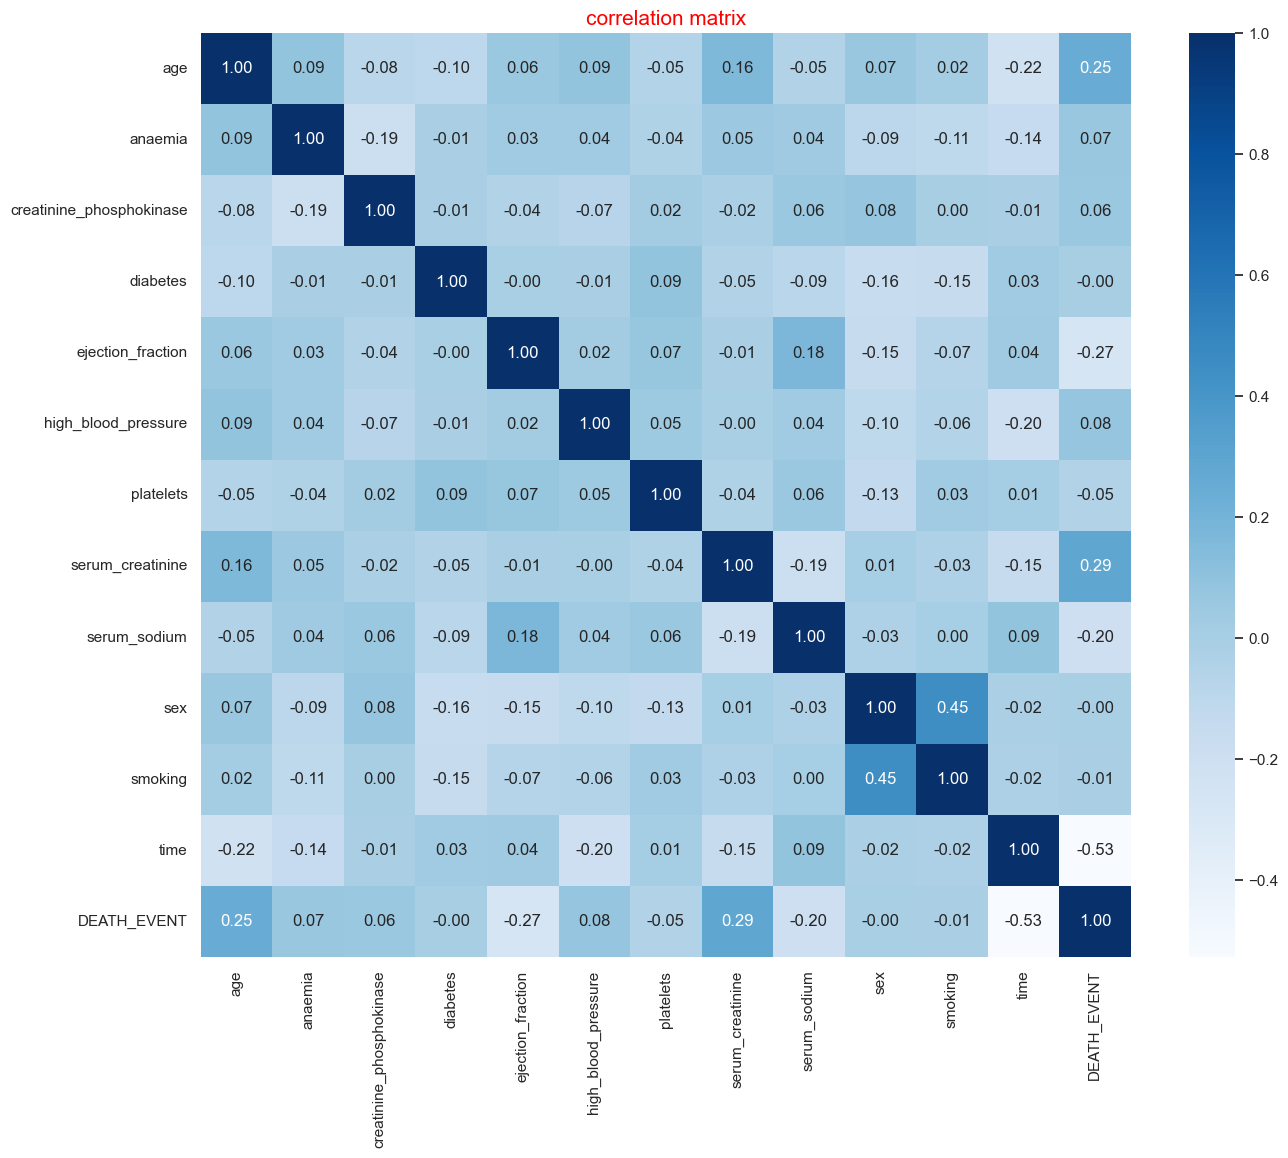

In [58]:

df_corr=df.select_dtypes(include=["float64","int64"]).corr()

plt.figure(figsize=(15,12))
plt.title("correlation matrix", color="red",fontsize=15)
sns.heatmap(df_corr,annot=True,cmap="Blues",fmt=".2f")
sns.set(font_scale=1,style='white')
plt.show()


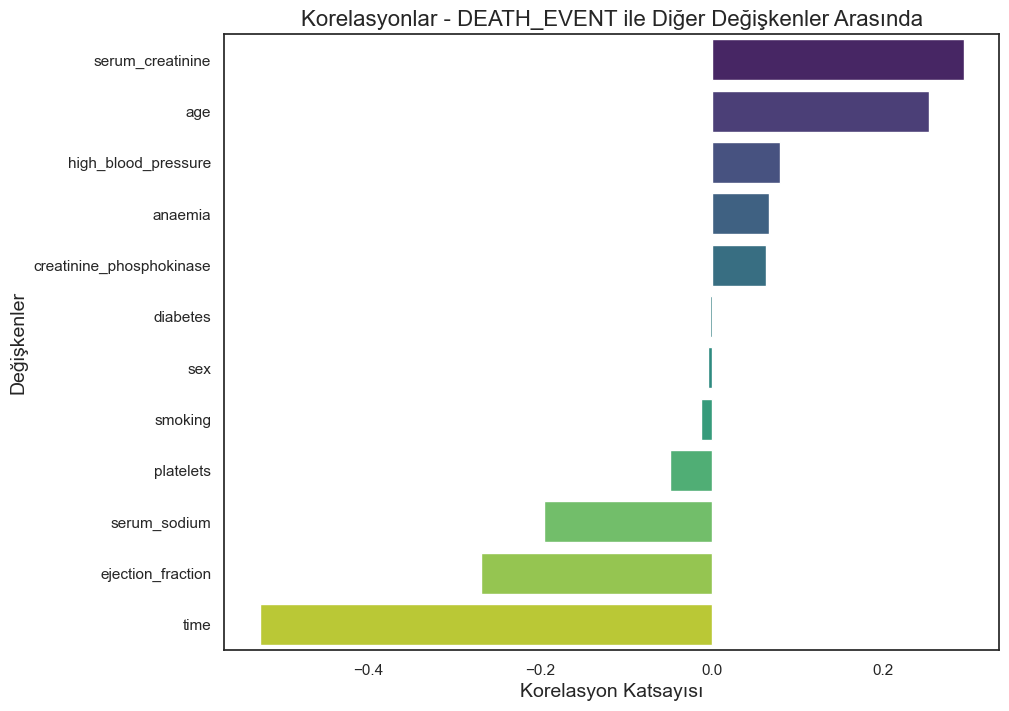

In [59]:
correlation_matrix = df.corr()  
gender_correlations = correlation_matrix['DEATH_EVENT'].drop('DEATH_EVENT').sort_values(ascending=False)  # Gender sütununun diğer sütunlarla korelasyonu



plt.figure(figsize=(10, 8))


sns.barplot(x=gender_correlations.values, y=gender_correlations.index, palette='viridis')


plt.title('Korelasyonlar - DEATH_EVENT ile Diğer Değişkenler Arasında', fontsize=16)
plt.xlabel('Korelasyon Katsayısı', fontsize=14)
plt.ylabel('Değişkenler', fontsize=14)


plt.show()

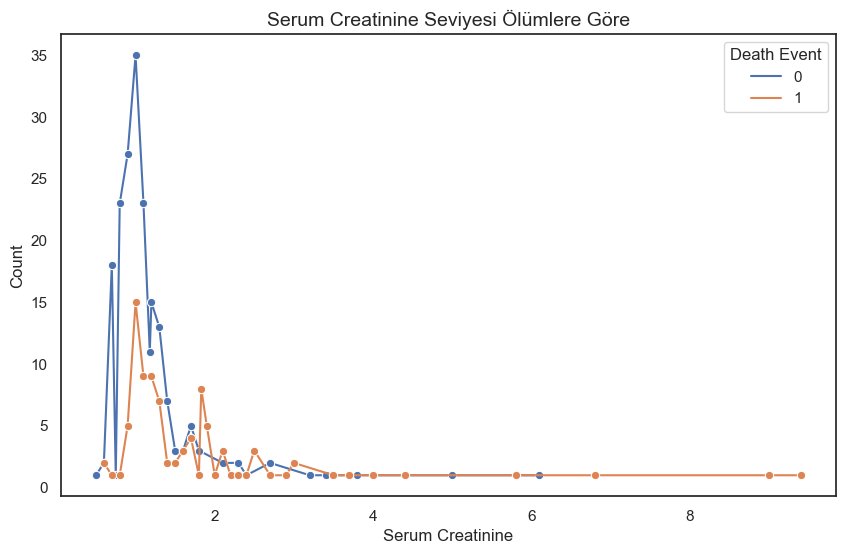

Ölümlere göre ortalama serum creatinine
0    2.020385
1    2.750938
Name: serum_creatinine, dtype: float64


In [60]:


df_grouped = df.groupby(['DEATH_EVENT', 'serum_creatinine']).size().reset_index(name='counts')


plt.figure(figsize=(10, 6))
sns.lineplot(data=df_grouped, x='serum_creatinine', y='counts', hue='DEATH_EVENT', marker='o')


plt.title('Serum Creatinine Seviyesi Ölümlere Göre', fontsize=14)
plt.xlabel('Serum Creatinine', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Death Event', loc='best')


plt.show()


print("Ölümlere göre ortalama serum creatinine\n0    2.020385\n1    2.750938\nName: serum_creatinine, dtype: float64")


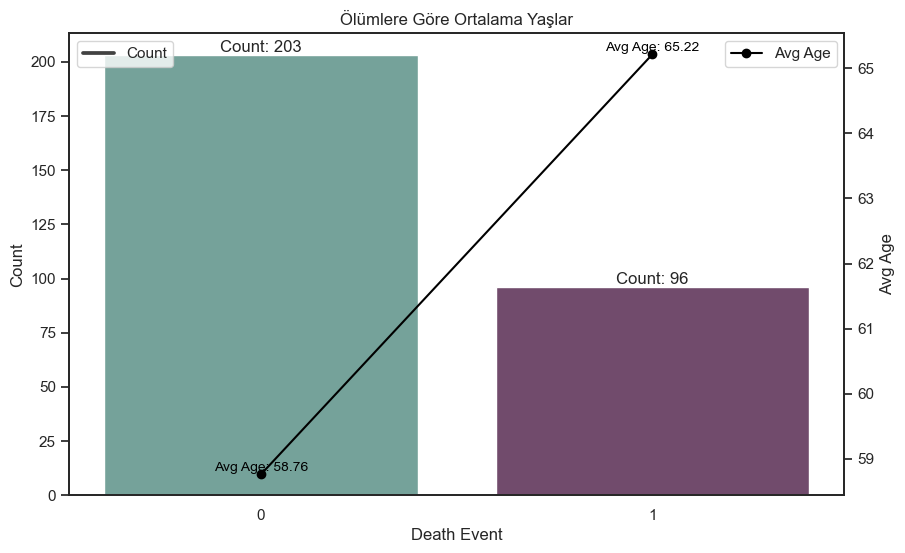

In [61]:


death_event_counts = df['DEATH_EVENT'].value_counts()
death_event_avg_age = df.groupby('DEATH_EVENT')['age'].mean()


fig, ax1 = plt.subplots(figsize=(10, 6))


sns.barplot(x=death_event_counts.index, y=death_event_counts.values, ax=ax1, palette=['#6daa9f', '#774571'])
ax1.set_ylabel('Count')
ax1.set_xlabel('Death Event')
ax1.set_title('Ölümlere Göre Ortalama Yaşlar')


for i, count in enumerate(death_event_counts.values):
    ax1.text(i, count + 0.05, f'Count: {count}', ha='center', va='bottom')


ax2 = ax1.twinx()
ax2.plot(death_event_avg_age.index, death_event_avg_age.values, 'o-', color='black')
ax2.set_ylabel('Avg Age')


for i, age in enumerate(death_event_avg_age.values):
    ax2.text(i, age, f'Avg Age: {round(age, 2)}', ha='center', va='bottom', fontsize=10, color='black')


ax1.legend(['Count'], loc='upper left')
ax2.legend(['Avg Age'], loc='upper right')

plt.show()


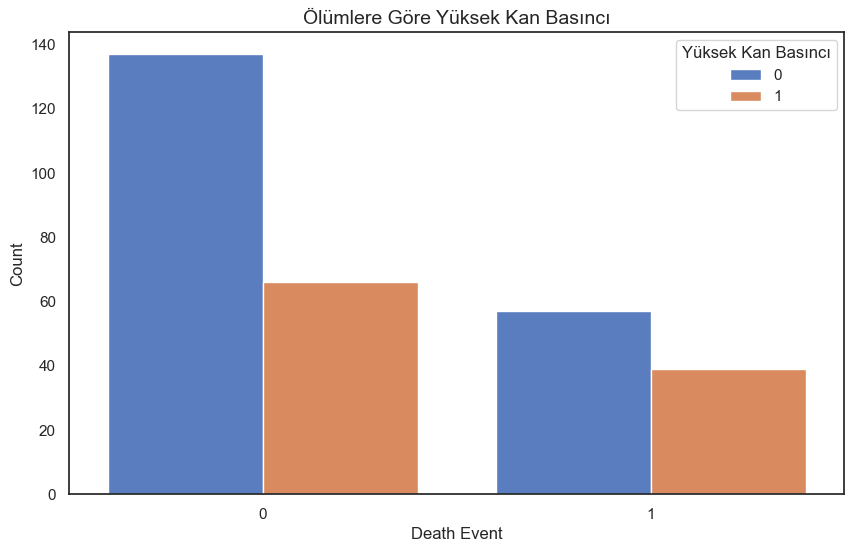

In [62]:


df_grouped = df.groupby(['DEATH_EVENT', 'high_blood_pressure']).size().reset_index(name='counts')


plt.figure(figsize=(10, 6))
sns.barplot(data=df_grouped, x='DEATH_EVENT', y='counts', hue='high_blood_pressure', palette='muted')
plt.title('Ölümlere Göre Yüksek Kan Basıncı', fontsize=14)
plt.xlabel('Death Event', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Yüksek Kan Basıncı')


plt.show()

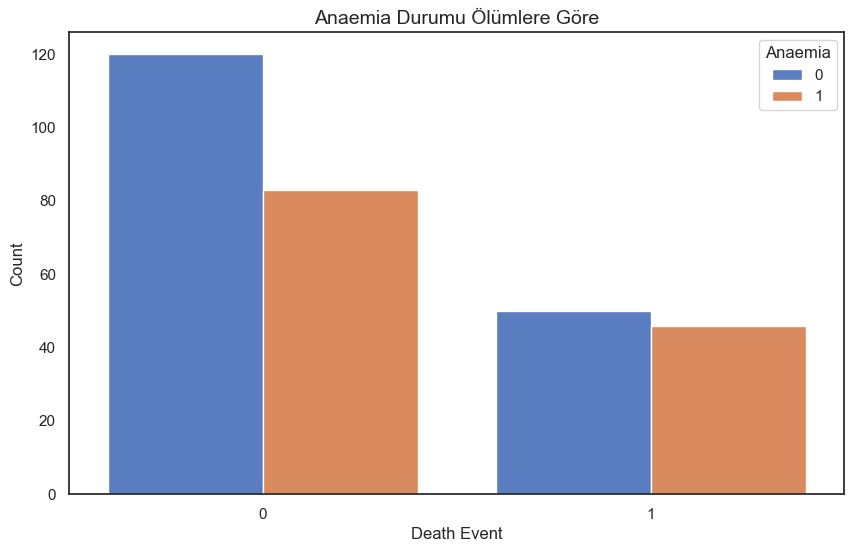

In [63]:

df_grouped = df.groupby(['DEATH_EVENT', 'anaemia']).size().reset_index(name='counts')


plt.figure(figsize=(10, 6))
sns.barplot(data=df_grouped, x='DEATH_EVENT', y='counts', hue='anaemia', palette='muted')


plt.title('Anaemia Durumu Ölümlere Göre', fontsize=14)
plt.xlabel('Death Event', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Anaemia')


plt.show()

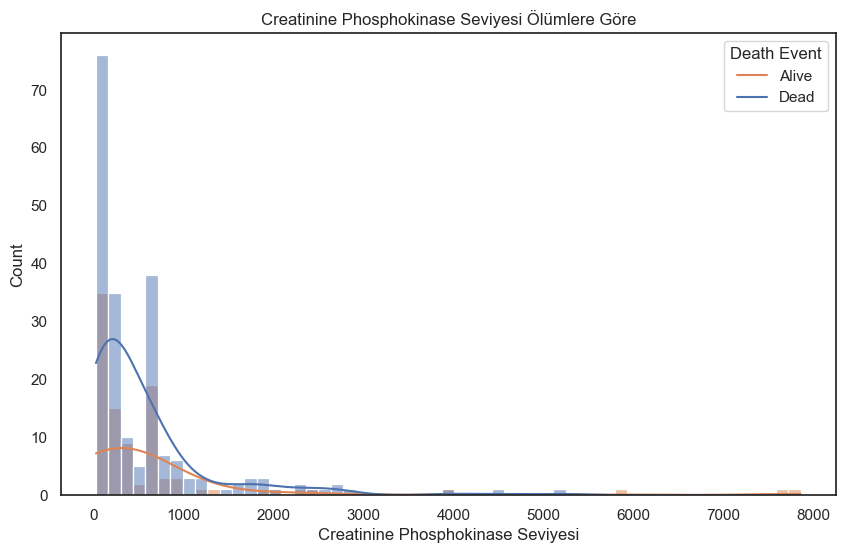

In [64]:

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='creatinine_phosphokinase', hue='DEATH_EVENT', kde=True)
plt.title('Creatinine Phosphokinase Seviyesi Ölümlere Göre')
plt.xlabel('Creatinine Phosphokinase Seviyesi')
plt.ylabel('Count')
plt.legend(title='Death Event', labels=['Alive', 'Dead'])
plt.show()


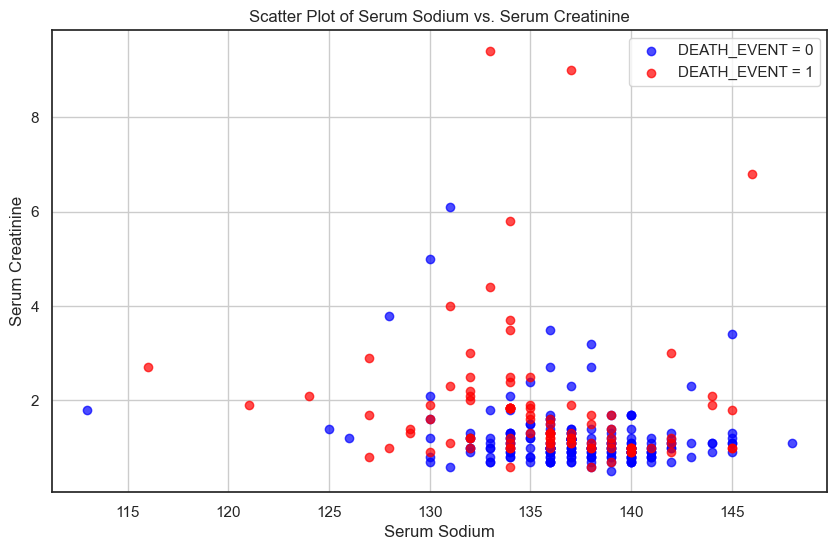

In [75]:

plt.figure(figsize=(10, 6))

plt.scatter(df[df['DEATH_EVENT'] == 0]['serum_sodium'], df[df['DEATH_EVENT'] == 0]['serum_creatinine'], 
            alpha=0.7, color='blue', label='DEATH_EVENT = 0')
plt.scatter(df[df['DEATH_EVENT'] == 1]['serum_sodium'], df[df['DEATH_EVENT'] == 1]['serum_creatinine'], 
            alpha=0.7, color='red', label='DEATH_EVENT = 1')

plt.title('Scatter Plot of Serum Sodium vs. Serum Creatinine')
plt.xlabel('Serum Sodium')
plt.ylabel('Serum Creatinine')
plt.grid(True)
plt.legend()
plt.show()


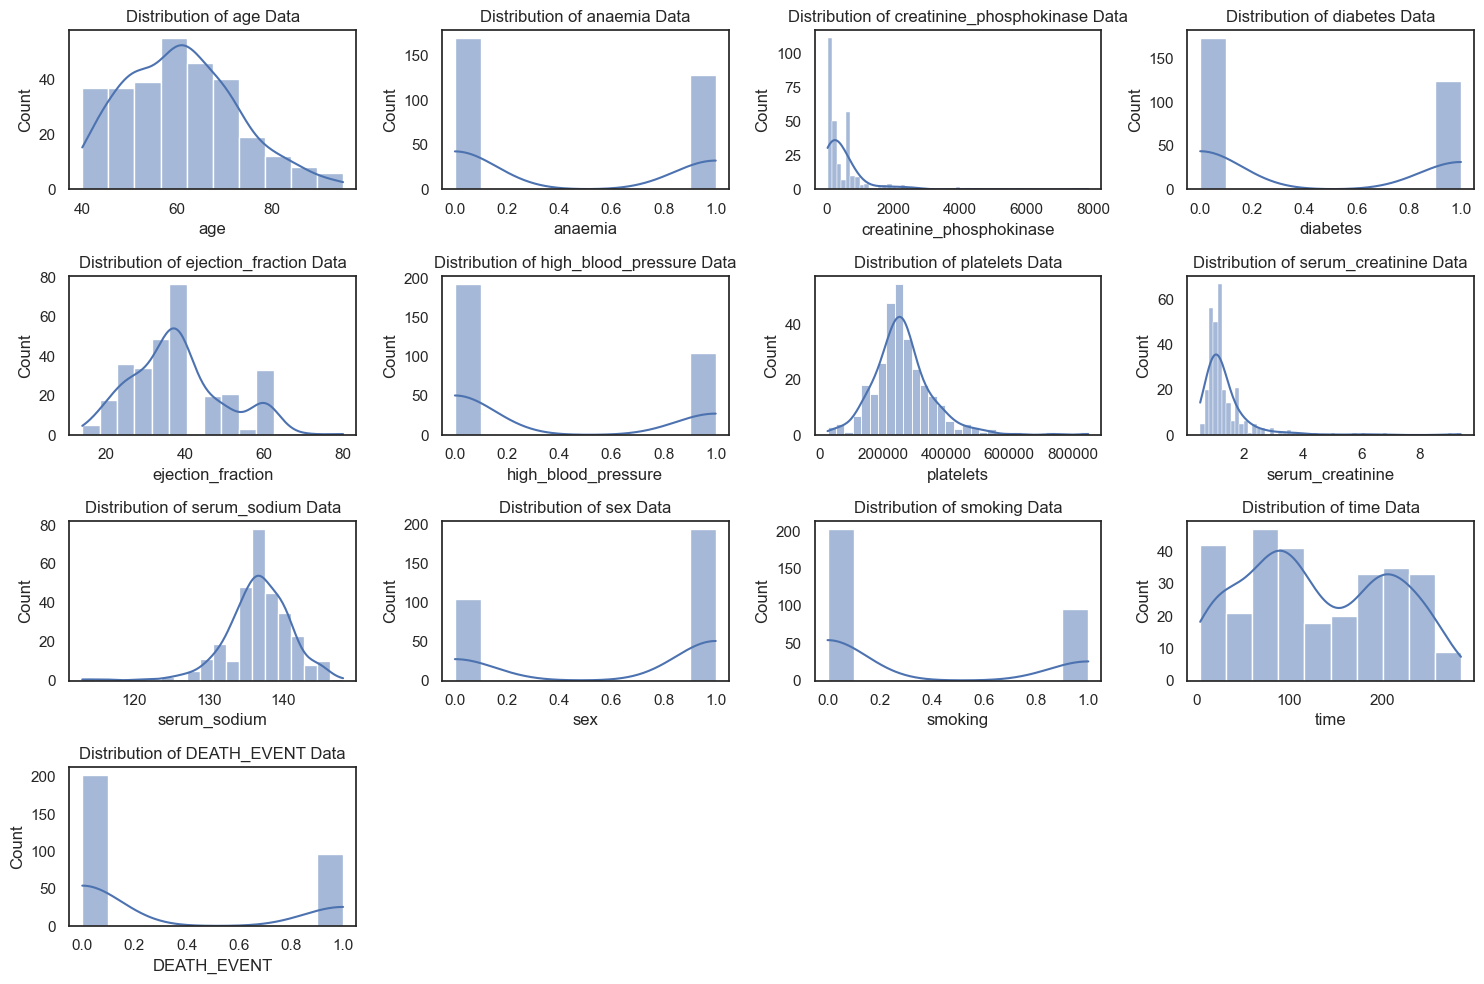

In [66]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(4,4,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

## Outliers

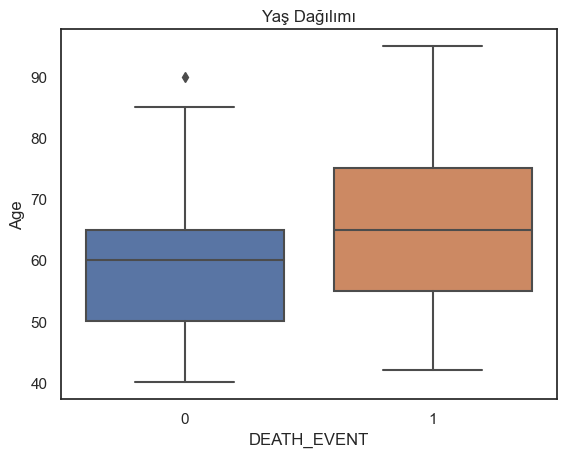

In [67]:
sns.boxplot(x='DEATH_EVENT', y='age', data=df)
plt.title('Yaş Dağılımı')
plt.xlabel('DEATH_EVENT')
plt.ylabel('Age')
plt.show()


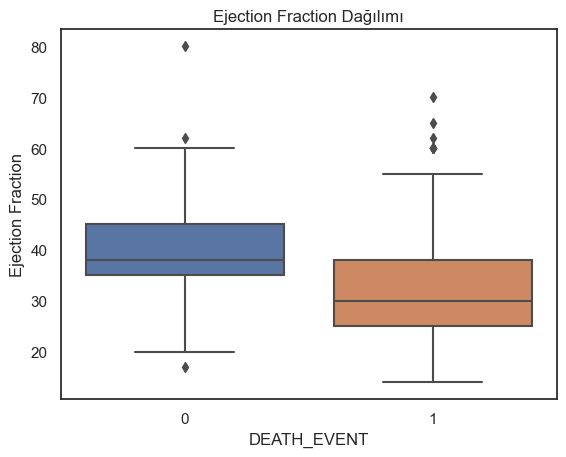

In [68]:
sns.boxplot(x='DEATH_EVENT', y='ejection_fraction', data=df)
plt.title('Ejection Fraction Dağılımı')
plt.xlabel('DEATH_EVENT')
plt.ylabel('Ejection Fraction')
plt.show()


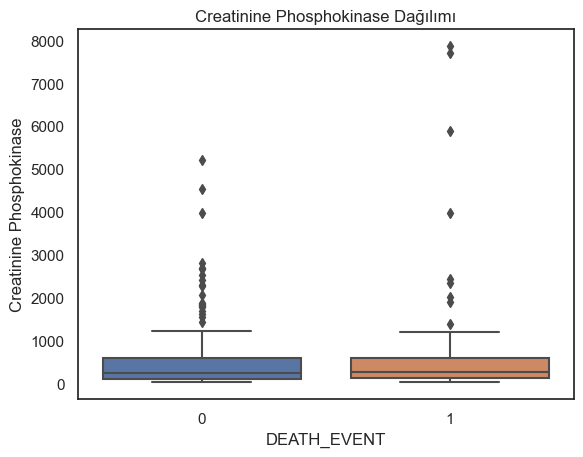

In [69]:
sns.boxplot(x='DEATH_EVENT', y='creatinine_phosphokinase', data=df)
plt.title('Creatinine Phosphokinase Dağılımı')
plt.xlabel('DEATH_EVENT')
plt.ylabel('Creatinine Phosphokinase')
plt.show()


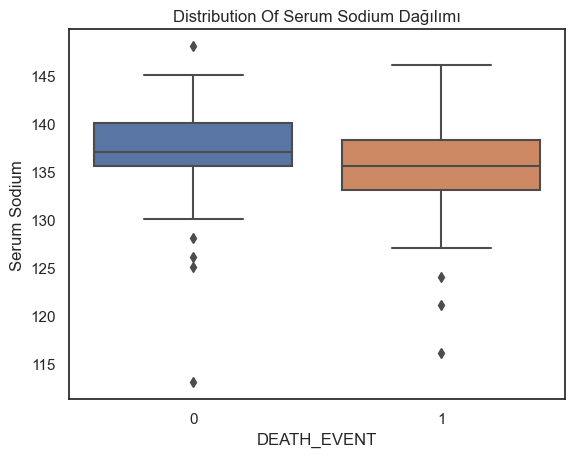

In [70]:
sns.boxplot(x='DEATH_EVENT', y='serum_sodium', data=df)
plt.title('Distribution Of Serum Sodium Dağılımı')
plt.xlabel('DEATH_EVENT')
plt.ylabel('Serum Sodium')
plt.show()


## Modeller

In [71]:

target = "DEATH_EVENT"
y = df_copy[target]
df.drop("DEATH_EVENT", axis=1, inplace=True)

def evaluate_models(n_splits):
    results = {
        'Logistic Regression': {'acc_log': [], 'best_fold': None, 'best_report': None, 'best_acc': None, 'best_cm': None},
        'Naive Bayes': {'acc_log': [], 'best_fold': None, 'best_report': None, 'best_acc': None, 'best_cm': None},
        'SVM': {'acc_log': [], 'best_fold': None, 'best_report': None, 'best_acc': None, 'best_cm': None},
        'ANN': {'acc_log': [], 'best_fold': None, 'best_report': None, 'best_acc': None, 'best_cm': None}
    }
    
    
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (trn_, val_) in enumerate(kf.split(X=df, y=y)):
        X_train = df.iloc[trn_]
        y_train = y.iloc[trn_]
        
        X_valid = df.iloc[val_]
        y_valid = y.iloc[val_]
        
        # Veriyi ölçeklendirme
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        
        # Logistic Regression
        clf_log = LogisticRegression()
        clf_log.fit(X_train, y_train)
        y_pred_log = clf_log.predict(X_valid)
        acc_log = roc_auc_score(y_valid, y_pred_log)
        results['Logistic Regression']['acc_log'].append(acc_log)
        
        if results['Logistic Regression']['best_acc'] is None or acc_log > results['Logistic Regression']['best_acc']:
            results['Logistic Regression']['best_fold'] = fold
            results['Logistic Regression']['best_report'] = classification_report(y_valid, y_pred_log)
            results['Logistic Regression']['best_acc'] = acc_log
            results['Logistic Regression']['best_cm'] = confusion_matrix(y_valid, y_pred_log)
        
        # Naive Bayes
        clf_nb = GaussianNB()
        clf_nb.fit(X_train, y_train)
        y_pred_nb = clf_nb.predict(X_valid)
        acc_nb = roc_auc_score(y_valid, y_pred_nb)
        results['Naive Bayes']['acc_log'].append(acc_nb)
        
        if results['Naive Bayes']['best_acc'] is None or acc_nb > results['Naive Bayes']['best_acc']:
            results['Naive Bayes']['best_fold'] = fold
            results['Naive Bayes']['best_report'] = classification_report(y_valid, y_pred_nb)
            results['Naive Bayes']['best_acc'] = acc_nb
            results['Naive Bayes']['best_cm'] = confusion_matrix(y_valid, y_pred_nb)
        
        # SVM
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train)
        y_pred_svm = clf_svm.predict(X_valid)
        acc_svm = roc_auc_score(y_valid, y_pred_svm)
        results['SVM']['acc_log'].append(acc_svm)
        
        if results['SVM']['best_acc'] is None or acc_svm > results['SVM']['best_acc']:
            results['SVM']['best_fold'] = fold
            results['SVM']['best_report'] = classification_report(y_valid, y_pred_svm)
            results['SVM']['best_acc'] = acc_svm
            results['SVM']['best_cm'] = confusion_matrix(y_valid, y_pred_svm)
        
        # ANN
        clf_ann = MLPClassifier()
        clf_ann.fit(X_train, y_train)
        y_pred_ann = clf_ann.predict(X_valid)
        acc_ann = roc_auc_score(y_valid, y_pred_ann)
        results['ANN']['acc_log'].append(acc_ann)
        
        if results['ANN']['best_acc'] is None or acc_ann > results['ANN']['best_acc']:
            results['ANN']['best_fold'] = fold
            results['ANN']['best_report'] = classification_report(y_valid, y_pred_ann)

            results['ANN']['best_fold'] = fold
            results['ANN']['best_report'] = classification_report(y_valid, y_pred_ann)
            results['ANN']['best_acc'] = acc_ann
            results['ANN']['best_cm'] = confusion_matrix(y_valid, y_pred_ann)
    
    for model_name, result in results.items():
        result['mean_acc'] = np.mean(result['acc_log'])
    
    return results

# Değerlendirme ve sonuçları bastırma
for n_splits in [5, 10]:
    results = evaluate_models(n_splits)
    
    print(f"\n{n_splits}-Fold Cross-Validation Results:\n")
    
    for model_name, result in results.items():
        print(f"{model_name} Results:")
        print(f"Best Fold: {result['best_fold']}")
        print(result['best_report'])
        print(f"Best ROC AUC Score: {result['best_acc']}")
        print(f"Average ROC AUC Score: {result['mean_acc']}\n")
        print("Confusion Matrix:")
        print(result['best_cm'])
        print("="*50)



5-Fold Cross-Validation Results:

Logistic Regression Results:
Best Fold: 2
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        46
           1       0.73      0.79      0.76        14

    accuracy                           0.88        60
   macro avg       0.83      0.85      0.84        60
weighted avg       0.89      0.88      0.88        60

Best ROC AUC Score: 0.8493788819875776
Average ROC AUC Score: 0.7512483254171234

Confusion Matrix:
[[42  4]
 [ 3 11]]
Naive Bayes Results:
Best Fold: 2
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        46
           1       0.57      0.57      0.57        14

    accuracy                           0.80        60
   macro avg       0.72      0.72      0.72        60
weighted avg       0.80      0.80      0.80        60

Best ROC AUC Score: 0.7204968944099378
Average ROC AUC Score: 0.676904234157431

Confusion Matrix:
[[40  6]
 [ 6  8]

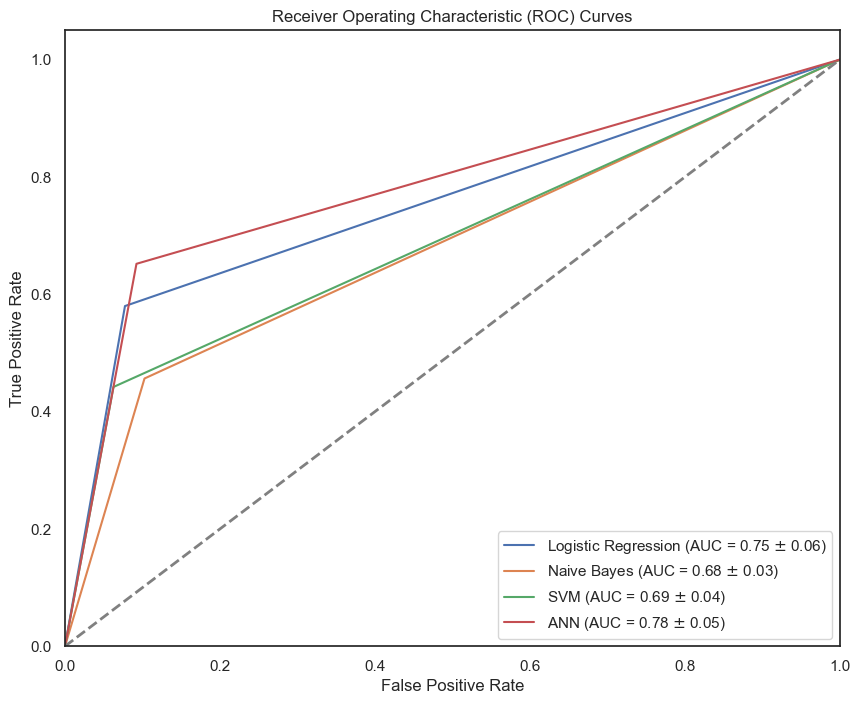

In [72]:


def evaluate_models(n_splits):
    results = {
        'Logistic Regression': {'fpr': [], 'tpr': [], 'roc_auc': []},
        'Naive Bayes': {'fpr': [], 'tpr': [], 'roc_auc': []},
        'SVM': {'fpr': [], 'tpr': [], 'roc_auc': []},
        'ANN': {'fpr': [], 'tpr': [], 'roc_auc': []}
    }
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for fold, (trn_, val_) in enumerate(kf.split(X=df, y=y)):
        X_train = df.iloc[trn_]
        y_train = y.iloc[trn_]
        
        X_valid = df.iloc[val_]
        y_valid = y.iloc[val_]
        
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        
        classifiers = {
            'Logistic Regression': LogisticRegression(),
            'Naive Bayes': GaussianNB(),
            'SVM': SVC(),
            'ANN': MLPClassifier()
        }
        
        for model_name, clf in classifiers.items():
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_valid)
            fpr, tpr, _ = roc_curve(y_valid, y_pred)
            roc_auc = auc(fpr, tpr)
            
            results[model_name]['fpr'].append(fpr)
            results[model_name]['tpr'].append(tpr)
            results[model_name]['roc_auc'].append(roc_auc)
    
    return results

# Modelleri değerlendirme
results = evaluate_models(n_splits=5)

# Her algoritmanın ROC eğrilerini çizin
plt.figure(figsize=(10, 8))
for model_name, result in results.items():
    mean_tpr = np.mean(result['tpr'], axis=0)
    mean_fpr = np.mean(result['fpr'], axis=0)
    mean_auc = np.mean(result['roc_auc'])
    std_auc = np.std(result['roc_auc'])
    plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


### Grafikteki modeller ve AUC değerleri:

Lojistik Regresyon (Mavi): AUC = 0.75 ± 0.06

Naive Bayes (Turuncu): AUC = 0.68 ± 0.03

Destek Vektör Makineleri (SVM) (Yeşil): AUC = 0.69 ± 0.04

Yapay Sinir Ağları (ANN) (Kırmızı): AUC = 0.77 ± 0.06


Yapay Sinir Ağları (ANN) en yüksek AUC değeri (0.77) ile en iyi performansı gösteren modeldir.
Lojistik Regresyon (0.75) ve SVM (0.69) benzer performans sergiliyor, ancak Lojistik Regresyon biraz daha iyi.
Naive Bayes (0.68) en düşük AUC değerine sahip, dolayısıyla diğer modellerden daha düşük bir performans gösteriyor.
Sonuç olarak, bu grafiğe göre Yapay Sinir Ağları (ANN) modelinin, ele alınan problemde en iyi performansı sergilediğini söyleyebiliriz. Diğer modeller arasında Lojistik Regresyon ve SVM, Naive Bayes'ten daha iyi performans gösteriyor.

In [76]:
!pip install pypandoc